In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt

In [193]:
import os
import pandas as pd

BASE_DIR = "Warp-D"

# Labels are in train/labels/(file_name).txt in the format: class x_center y_center width height
labels_dir = os.path.join(BASE_DIR, "train/labels")
labels = os.listdir(labels_dir)

# Load the labels into a pandas dataframe
df = pd.DataFrame(columns=["file_name", "class", "x_center",
              "y_center", "width", "height"])

def load_labels(labels_dir):
  df = pd.DataFrame(columns=["file_name", "class", "x_center",
              "y_center", "width", "height"])
  for label in labels:
    with open(os.path.join(labels_dir, label), "r") as f:
      lines = f.readlines()
      for line in lines:
        line = line.strip().split(" ")
        if len(line) != 5:
          continue
        
        new_row = {"file_name": label.split(".")[0], 
              "class": line[0],
              "x_center": line[1], 
              "y_center": line[2], 
              "width": line[3], 
              "height": line[4]}
        
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
  return df

df = load_labels(labels_dir)

In [194]:
df.head()

,file_name,class,x_center,y_center,width,height
0,prepared_data_all_MGS_19-Oct_22-03-50,22,0.743750,0.464352,0.096875,0.247222
1,prepared_data_all_MGS_19-Oct_19-20-46,3,0.176302,0.106944,0.074479,0.212037
2,Robo_25-Mar_12-03-19,15,0.502344,0.213426,0.116146,0.345370
3,Robo_25-Mar_12-03-19,21,0.555208,0.826389,0.218750,0.158333
4,Robo_25-Mar_12-03-19,23,0.655208,0.578704,0.183333,0.398148


(540, 960, 3)
                    file_name class  x_center  y_center     width    height
1547  POSAD_1_11-Sep_09-43-28     7  0.534635  0.154630  0.180729  0.231481
1548  POSAD_1_11-Sep_09-43-28     2  0.410417  0.776852  0.197917  0.235185
1549  POSAD_1_11-Sep_09-43-28     4  0.296615  0.706944  0.108854  0.187963
1550  POSAD_1_11-Sep_09-43-28     8  0.360938  0.223148  0.095833  0.138889
1551  POSAD_1_11-Sep_09-43-28     0  0.616927  0.111574  0.098437  0.217593
1552  POSAD_1_11-Sep_09-43-28     4  0.472396  0.933796  0.119792  0.132407


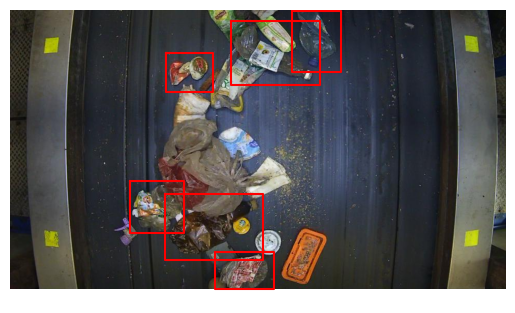

In [195]:
# Load example image and display
img_name = "POSAD_1_11-Sep_09-43-28"
# Filter the dataframe to only include the bounding boxes for the image we loaded
img_boxes = df[df["file_name"] == img_name]

img = plt.imread(os.path.join(BASE_DIR, "train/images/", img_name + ".jpg"))
plt.imshow(img)
plt.axis("off")

print(img.shape)
print(img_boxes)

# Display bounding boxes
def disp_bb(img, img_boxes):
  for index, row in img_boxes.iterrows():
    # Values are normalized
    x_center = float(row["x_center"]) * img.shape[1]
    y_center = float(row["y_center"]) * img.shape[0]
    width = float(row["width"]) * img.shape[1]
    height = float(row["height"]) * img.shape[0]
    
    x1 = x_center - width/2
    x2 = x_center + width/2
    y1 = y_center - height/2
    y2 = y_center + height/2
    
    plt.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], color="red")

disp_bb(img, img_boxes)

plt.show()

In [250]:
import random 
import math

random.seed(42)

def get_random_image_patch(img, img_boxes, width, height):
    # display the image
    
    random_box = img_boxes.sample()
    
    x_center = float(random_box["x_center"]) * img.shape[1]
    y_center = float(random_box["y_center"]) * img.shape[0]
    
    x1 = x_center - width / 2
    x2 = x_center + width / 2
    y1 = y_center - height / 2
    y2 = y_center + height / 2
    
    # to integers
    x1, x2, y1, y2 = map(int, [x1, x2, y1, y2])
    
    cropped_img = img[y1:y2, x1:x2]

    return cropped_img


def cutmix(img, img_boxes, img2, img_2_boxes, threshold=0.3):
    img = np.copy(img)

    for i, bb in img_boxes.iterrows():
        # original bounding box
        x_center = float(bb["x_center"]) * img.shape[1]
        y_center = float(bb["y_center"]) * img.shape[0]
        width_bb = float(bb["width"])  * img.shape[1]
        height_bb = float(bb["height"])  * img.shape[0]
        
        #original area
        area = width_bb * height_bb
        
        # new bounding box - 30 percent of the original bounding box
        reduction_factor = np.sqrt(threshold)
        width = width_bb * reduction_factor
        height = height_bb * reduction_factor
        
        x1 = x_center - width / 2
        x2 = x_center + width / 2
        y1 = y_center - height / 2
        y2 = y_center + height / 2
        
        # move the new bounding box to a random location within the original bounding box
        random_x = random.uniform(0, width_bb/1.9)
        random_y = random.uniform(0, height_bb/1.9)
        
        img_x1 = x1 + random_x
        img_x2 = x2 + random_x
        img_y1 = y1 + random_y
        img_y2 = y2 + random_y
        
        # map to integers
        img_x1, img_x2, img_y1, img_y2 = map(int, [img_x1, img_x2, img_y1, img_y2])
                
        # loop through rectangle coords and set them to 0
        for y in range(img_y1, img_y2):
            for x in range(img_x1, img_x2):
                if 0 <= y < img.shape[0] and 0 <= x < img.shape[1]:
                    img[y, x] = [0, 0, 0]
                    
        img_2 = get_random_image_patch(img2, img_2_boxes, img_x2 - img_x1, img_y2 - img_y1)
        
        # paste the new image onto the original image
        for y in range(img_y1, img_y2):
            for x in range(img_x1, img_x2):
                if 0 <= y < img.shape[0] and 0 <= x < img.shape[1]:
                    img[y, x] = img_2[y - img_y1, x - img_x1]
        
        plt.plot([img_x1, img_x2, img_x2, img_x1, img_x1], [img_y1, img_y1, img_y2, img_y2, img_y1], color="blue")
        
                    
    # y labels stay the same
    return img, img_boxes


/var/folders/py/wfd5gjj55nx4cqtdvltb22mw0000gp/T/ipykernel_87305/100489202.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x_center = float(random_box["x_center"]) * img.shape[1]
/var/folders/py/wfd5gjj55nx4cqtdvltb22mw0000gp/T/ipykernel_87305/100489202.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y_center = float(random_box["y_center"]) * img.shape[0]


(-0.5, 959.5, 539.5, -0.5)

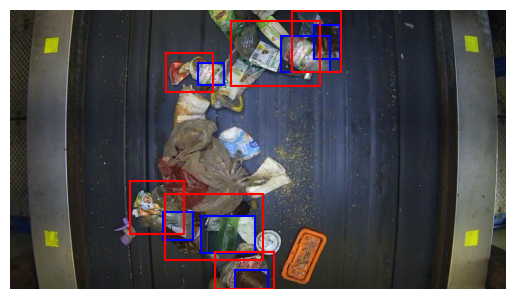

In [251]:
img_name = "POSAD_1_11-Sep_09-43-28"
img = plt.imread(os.path.join(BASE_DIR, "train/images/", img_name + ".jpg"))
img_boxes = df[df["file_name"] == img_name]

img_2_name = "POSAD_1_13-Sep_01-00-20"
img_2 = plt.imread(os.path.join(BASE_DIR, "train/images/", img_2_name + ".jpg"))
img_2_boxes = df[df["file_name"] == img_2_name]

img, img_boxes = cutmix(img, img_boxes, img_2, img_2_boxes)

# Display bounding boxes
disp_bb(img, img_boxes)
plt.imshow(img)
plt.axis("off")